In [1]:
from IPython.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [4]:
local_planner_color = {'dwa': 'blue', 'arena': 'orange', 'teb': 'green'}
local_planner_symbol = {'dwa': 'o', 'arena': '^', 'teb': 'x'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 200
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2


In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df = pd.read_csv(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results.csv"))
# with open(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']
# Filter only considering TEB local planner
df = df[df.local_planner_node == 'teb'] 

if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    445

## Run Parameters

    amcl_alpha_factor                                                      [1.0]

    available_cpu_threads                                                  [8]

    environment_name                                                       ['7A-2', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['global_planner']

    include_costmap_obstacles                                              [False, True]

    include_dynamic_obstacles                                              [False, True]

    local_planner_node                                                     ['teb']

    localization_node                                                      ['amcl']

    min_turning_radius                                                     [0.0, 0.1]

    pedestrian_max_vel                                                     [0.6, nan, 0.3]

    pedestrian_number                                                      [0, 5, 100]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    run_replication_index                                                  [0]

    beta_1                                                                 [0.01, 0.02]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.01, 0.02]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    collision_rate                                                         min:          0             avg:     0.1933             max:          1             nan:          0

    collision_time                                                         min:       9.08             avg:      84.66             max:      376.6             nan:        359

    collision_rate_version                                                 [3]

    minimum_clearance                                                      min:          0             avg:     0.2476             max:       2.43             nan:          0

    average_clearance                                                      min:    0.01432             avg:     0.8357             max:       2.72             nan:          0

    median_clearance                                                       min:          0             avg:     0.7435             max:      2.644             nan:          0

    maximum_clearance                                                      min:     0.5783             avg:      1.946             max:      3.308             nan:          0

    clearance_version                                                      [3]

    trajectory_length                                                      min:     0.7721             avg:      23.93             max:      111.1             nan:          0

    trajectory_length_version                                              [1]

    execution_time                                                         min:      3.299             avg:      106.8             max:      571.6             nan:          0

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.7483             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   0.007728             avg:     0.1354             max:       3.21             nan:          0

    odometry_error_alpha_1_std                                             min:   0.003967             avg:     0.7546             max:      18.54             nan:          0

    odometry_error_alpha_2_mean                                            min:   0.001381             avg:     0.3376             max:      15.63             nan:          0

    odometry_error_alpha_2_std                                             min:   0.001397             avg:      1.617             max:      38.89             nan:          0

    odometry_error_alpha_3_mean                                            min:      0.011             avg:    0.02968             max:      1.652             nan:          0

    odometry_error_alpha_3_std                                             min:  0.0002965             avg:    0.06194             max:      2.119             nan:          0

    odometry_error_alpha_4_mean                                            min:   0.001526             avg:    0.05917             max:     0.8393             nan:          0

    odometry_error_alpha_4_std                                             min:   0.001252             avg:      0.104             max:      3.226             nan:          0

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:    0.02147             avg:     0.3387             max:      12.04             nan:          0

    localization_update_absolute_translation_error_std                     min:    0.00368             avg:     0.2559             max:      12.83             nan:          0

    localization_update_absolute_rotation_error_mean                       min:   0.005459             avg:    0.05296             max:      1.595             nan:          0

    localization_update_absolute_rotation_error_std                        min:    0.00116             avg:      0.078             max:      1.254             nan:          0

    localization_update_relative_translation_error_mean                    min:   0.002676             avg:    0.01745             max:     0.2852             nan:          0

    localization_update_relative_translation_error_std                     min:   0.002743             avg:    0.03489             max:      1.421             nan:          0

    localization_update_relative_rotation_error_mean                       min:   0.001973             avg:    0.01768             max:     0.5291             nan:          0

    localization_update_relative_rotation_error_std                        min:   0.001859             avg:    0.06364             max:     0.6495             nan:          0

    localization_update_normalized_relative_translation_error_mean         min:    0.03062             avg:     0.2366             max:      5.315             nan:          0

    localization_update_normalized_relative_translation_error_std          min:    0.02165             avg:     0.6509             max:      28.77             nan:          0

    localization_update_normalized_relative_rotation_error_mean            min:    0.01514             avg:     0.1351             max:      2.625             nan:          0

    localization_update_normalized_relative_rotation_error_std             min:    0.01397             avg:     0.5031             max:      5.537             nan:          0

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:    0.01771             avg:     0.2565             max:      7.426             nan:          0

    collisionless_localization_update_absolute_translation_error_std       min:          0             avg:     0.1782             max:      5.139             nan:          0

    absolute_rotation_error                                                min:   0.005459             avg:    0.03199             max:     0.7769             nan:          0

    collisionless_localization_update_absolute_rotation_error_std          min:          0             avg:    0.05423             max:     0.6655             nan:          0

    collisionless_localization_update_relative_translation_error_mean      min:   0.002679             avg:    0.01637             max:     0.2852             nan:          0

    collisionless_localization_update_relative_translation_error_std       min:          0             avg:    0.02872             max:      1.136             nan:          0

    collisionless_localization_update_relative_rotation_error_mean         min:    0.00173             avg:     0.0129             max:     0.1826             nan:          0

    collisionless_localization_update_relative_rotation_error_std          min:          0             avg:    0.05332             max:     0.6602             nan:          0

    normalized_relative_translation_error                                  min:    0.03062             avg:     0.2247             max:      5.315             nan:          1

    collisionless_localization_update_normalized_relative_translation_error_std min:    0.02165             avg:     0.5892             max:      28.77             nan:          1

    normalized_relative_rotation_error                                     min:    0.01514             avg:     0.1991             max:      5.254             nan:          0

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:     0.8264             max:      27.97             nan:          0

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:    0.02738             avg:     0.7255             max:       2.35             nan:          0

    localization_update_rate_std                                           min:    0.02983             avg:     0.4158             max:      7.933             nan:          0

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:    0.05329             avg:     0.2416             max:     0.3513             nan:          0

    average_rotation_velocity                                              min:    0.02892             avg:     0.2377             max:      9.113             nan:          0

    translation_rotation_product                                           min:   0.007596             avg:    0.05433             max:      2.765             nan:          0

    average_translation_acceleration                                       min:    0.02182             avg:     0.1297             max:      1.308             nan:          0

    average_rotation_acceleration                                          min:    0.03893             avg:     0.2257             max:       1.17             nan:          0

    translation_rotation_acceleration_product                              min:   0.001397             avg:    0.05172             max:      4.157             nan:          0

    average_velocity_atan                                                  min:    0.09708             avg:     0.5155             max:      1.476             nan:          0

    motion_characteristics_version                                         [4]

    move_base_cpu_time                                                     min:       0.89             avg:      39.47             max:      593.1             nan:          0

    simulation_cpu_time                                                    min:      10.79             avg:      185.9             max:       2568             nan:          0

    system_cpu_time                                                        min:       3.91             avg:      52.05             max:      642.9             nan:          0

    move_base_max_memory                                                   min:      40.57             avg:      71.44             max:      328.8             nan:          0

    simulation_max_memory                                                  min:      340.5             avg:      474.3             max:      856.8             nan:          0

    system_max_memory                                                      min:      133.2             avg:      195.1             max:      519.7             nan:          0

    cpu_time_and_max_memory_version                                        [6]

    max_cmd_vel_translation                                                min:   0.003039             avg:     0.2594             max:       0.26             nan:          0

    max_cmd_vel_rotation                                                   min:          0             avg:     0.9429             max:          1             nan:          0

    mean_cmd_vel_translation                                               min:    0.00011             avg:     0.2254             max:     0.2599             nan:          0

    mean_cmd_vel_rotation                                                  min:    -0.8021             avg:    0.00363             max:     0.9221             nan:          0

    cmd_vel_metrics_version                                                [2]

    normalized_curvature                                                   min:   0.002605             avg:    0.03537             max:     0.5684             nan:          0

    normalized_curvature_version                                           [1]

    pedestrian_encounters                                                  min:          0             avg:      3.016             max:        103             nan:          0

    pedestrian_encounters_version                                          [4]

    average_velocity                                                       min:     0.0367             avg:      0.224             max:     0.5922             nan:          0

    norm_execution_time                                                    min:     0.2649             avg:       1.57             max:       22.6             nan:          9

In [6]:
df.groupby(by=['include_costmap_obstacles', 'include_dynamic_obstacles']).agg(['mean', 'count'])[['success_rate', 'move_base_cpu_time']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate       move_base_cpu_time      
                                                            mean count               mean count
include_costmap_obstacles include_dynamic_obstacles                                            
True                      True                             0.970   100             31.201   100
False                     True                             0.885    96             10.740    96
                          False                            0.821   151             16.053   151
True                      False                            0.276    98            112.118    98

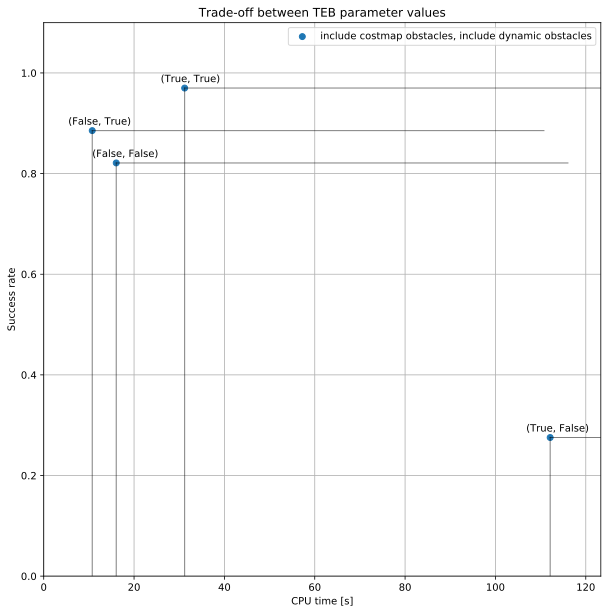

In [7]:
import matplotlib.patches as patches

df_success_cpu_trade_off = df.groupby(by=['include_costmap_obstacles', 'include_dynamic_obstacles']).agg('mean')[['success_rate', 'move_base_cpu_time']].sort_values(by='success_rate', ascending=False)

fig, ax = plt.subplots()

x = list(df_success_cpu_trade_off.move_base_cpu_time)
y = list(df_success_cpu_trade_off.success_rate)
labels = list(df_success_cpu_trade_off.index)

for x_i, y_i in zip(x, y):
    plt.plot([x_i, x_i+100], [y_i, y_i], color='black', linewidth=1, alpha=0.5)
    plt.plot([x_i, x_i], [-100, y_i], color='black', linewidth=1, alpha=0.5)

for i, label in enumerate(labels):
    ax.annotate(label, xy=(x[i], y[i]), xytext=(-24, 6) , xycoords='data', textcoords='offset points')

ax.scatter(df_success_cpu_trade_off.move_base_cpu_time, df_success_cpu_trade_off.success_rate, label=', '.join(df_success_cpu_trade_off.index.names).replace('_', ' '))
plt.xlabel('CPU time [s]')
plt.ylabel('Success rate')
plt.xlim([0, 1.1*df_success_cpu_trade_off.move_base_cpu_time.max()])
plt.ylim([0, 1.1])
plt.title("Trade-off between TEB parameter values")

plt.legend()
plt.grid()
plt.show()



In [8]:
df.groupby(by=['min_turning_radius', 'include_costmap_obstacles', 'include_dynamic_obstacles']).agg(['mean', 'count'])[['success_rate', 'collision_rate', 'move_base_cpu_time', 'move_base_max_memory']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate       collision_rate       move_base_cpu_time       move_base_max_memory      
                                                                               mean count           mean count               mean count                 mean count
min_turning_radius include_costmap_obstacles include_dynamic_obstacles                                                                                            
0.100              True                      True                             0.980    50          0.000    50             34.534    50               68.034    50
0.000              True                      True                             0.960    50          0.000    50             27.868    50               69.243    50
0.100              False                     True                             0.922    51          0.000    51             10.936    51               66.193    51
0.000              False                     True                             0.844    45          0.044    45             10.518    45               77.311    45
0.100              False                     False                            0.831    77          0.104    77             15.198    77               67.117    77
0.000              False                     False                            0.811    74          0.149    74             16.942    74               76.567    74
                   True                      False                            0.312    48          0.646    48            114.212    48               75.269    48
0.100              True                      False                            0.240    50          0.680    50            110.108    50               72.506    50

In [9]:
df.groupby(by=['min_turning_radius', 'include_costmap_obstacles', 'include_dynamic_obstacles']).agg(['mean', 'count'])[['success_rate', 'collision_rate', 'move_base_cpu_time', 'move_base_max_memory']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate       collision_rate       move_base_cpu_time       move_base_max_memory      
                                                                               mean count           mean count               mean count                 mean count
min_turning_radius include_costmap_obstacles include_dynamic_obstacles                                                                                            
0.100              True                      True                             0.980    50          0.000    50             34.534    50               68.034    50
0.000              True                      True                             0.960    50          0.000    50             27.868    50               69.243    50
0.100              False                     True                             0.922    51          0.000    51             10.936    51               66.193    51
0.000              False                     True                             0.844    45          0.044    45             10.518    45               77.311    45
0.100              False                     False                            0.831    77          0.104    77             15.198    77               67.117    77
0.000              False                     False                            0.811    74          0.149    74             16.942    74               76.567    74
                   True                      False                            0.312    48          0.646    48            114.212    48               75.269    48
0.100              True                      False                            0.240    50          0.680    50            110.108    50               72.506    50

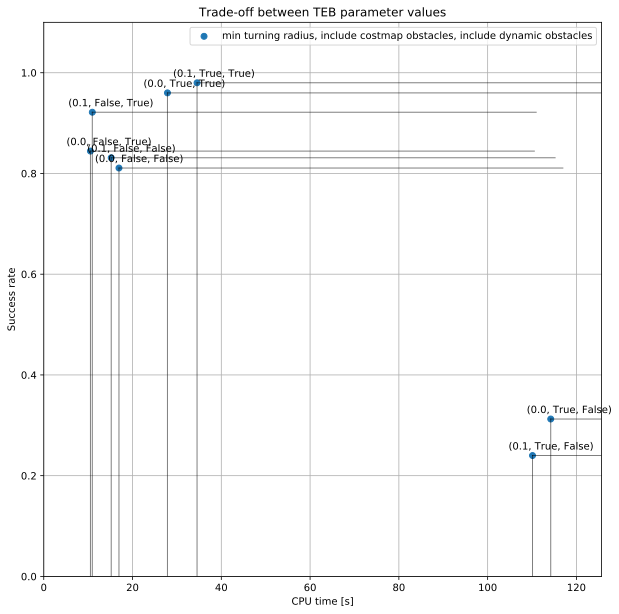

In [10]:
import matplotlib.patches as patches

df_success_cpu_trade_off = df.groupby(by=['min_turning_radius', 'include_costmap_obstacles', 'include_dynamic_obstacles']).agg('mean')[['success_rate', 'move_base_cpu_time']].sort_values(by='success_rate', ascending=False)

fig, ax = plt.subplots()

x = list(df_success_cpu_trade_off.move_base_cpu_time)
y = list(df_success_cpu_trade_off.success_rate)
labels = list(df_success_cpu_trade_off.index)

for x_i, y_i in zip(x, y):
    plt.plot([x_i, x_i+100], [y_i, y_i], color='black', linewidth=1, alpha=0.5)
    plt.plot([x_i, x_i], [-100, y_i], color='black', linewidth=1, alpha=0.5)

for i, label in enumerate(labels):
    ax.annotate(label, xy=(x[i], y[i]), xytext=(-24, 6) , xycoords='data', textcoords='offset points')

ax.scatter(df_success_cpu_trade_off.move_base_cpu_time, df_success_cpu_trade_off.success_rate, label=', '.join(df_success_cpu_trade_off.index.names).replace('_', ' '))
plt.xlabel('CPU time [s]')
plt.ylabel('Success rate')
plt.xlim([0, 1.1*df_success_cpu_trade_off.move_base_cpu_time.max()])
plt.ylim([0, 1.1])
plt.title("Trade-off between TEB parameter values")

plt.legend()
plt.grid()
plt.show()



In [11]:
df[df.pedestrian_number == 100]['run_id']

0      session_2023-03-09_10-06-47_065460_run_000000000
10     session_2023-03-09_10-06-47_065460_run_000000010
412    session_2023-03-08_09-44-57_680024_run_000000001
413    session_2023-03-08_09-44-57_680024_run_000000002
415    session_2023-03-08_09-44-57_680024_run_000000004
416    session_2023-03-08_09-44-57_680024_run_000000005
426    session_2023-03-08_09-44-57_680024_run_000000016
432    session_2023-03-08_09-44-57_680024_run_000000022
433    session_2023-03-08_09-44-57_680024_run_000000023
439    session_2023-03-08_09-45-16_063829_run_000000002
445    session_2023-03-08_09-45-16_063829_run_000000008
446    session_2023-03-08_09-45-16_063829_run_000000010
453    session_2023-03-08_09-45-16_063829_run_000000018
457    session_2023-03-08_09-45-16_063829_run_000000024
460    session_2023-03-08_09-45-16_063829_run_000000027
464    session_2023-03-08_09-45-16_063829_run_000000031
465    session_2023-03-08_09-45-16_063829_run_000000032
473    session_2023-03-09_10-06-31_358011_run_00